# Time interpolation notebook

Time analysis for hexagons without nodes and time data.

## Import libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import math
import shapely
import h3

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-08-07 16:12:00 Configured OSMnx 1.1.2
2023-08-07 16:12:00 HTTP response caching is on


## Download data

In [2]:
city = 'Guadalajara'

Municipality limits

In [3]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head()

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara
2,14044,14,044,Ixtlahuacán de los Membrillos,"POLYGON ((-103.20756 20.47596, -103.20698 20.4...",Guadalajara
3,14051,14,051,Juanacatlán,"POLYGON ((-103.13701 20.57179, -103.13028 20.5...",Guadalajara
4,14070,14,070,El Salto,"POLYGON ((-103.31558 20.57832, -103.31525 20.5...",Guadalajara


Urban area

In [7]:
# donwload hexagons with urban limits
cvegeo_list = list(mun_gdf.CVEGEO.unique())
hex_gdf = gpd.GeoDataFrame()
hex_schema = 'censo'
hex_folder = 'hex_bins_pop_2020'

# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_gdf = pd.concat([hex_gdf, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_gdf.shape)
hex_gdf.head(2)

(1187, 225)


,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,135.64044,137.528090,13.123595,6.831461,6.292135,260.044950,...,13.662921,66.06741,34.426968,56.808990,9.168539,7.011236,2.067416,4.134831,33.348316,0.539326
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,98.333336,46.00000,43.333332,4.666666,2.333333,2.333333,84.666664,...,3.000000,22.00000,11.000000,18.666666,3.000000,2.000000,0.000000,0.000000,9.333333,0.000000


<AxesSubplot: >

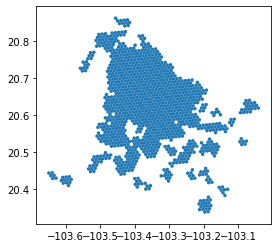

In [8]:
hex_gdf.plot()

Nodes

In [10]:
hex_gdf = hex_gdf.set_crs("EPSG:4326")
urb_buffer = hex_gdf.to_crs("EPSG:6372").buffer(2500)
urb_buffer = gpd.GeoDataFrame(geometry=urb_buffer)
urb_buffer = urb_buffer.dissolve()
urb_buffer = urb_buffer.to_crs("EPSG:4326")

In [ ]:
schema = 'prox_analysis'
nodes_folder = 'nodes_proximity_2020'
query = f"SELECT * FROM {schema}.{nodes_folder} WHERE \"metropolis\" LIKE \'{city}\'"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

In [ ]:
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()
print(nodes_geom.shape)
nodes_geom.head(2)

In [ ]:
nodes_analysis = nodes_geom.copy()

for amenidad in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})
    if nodes_tmp[amenidad].mean() == 0:
        nodes_tmp[amenidad] = -1
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
print(nodes_analysis.shape)
nodes_analysis.head(2)

## Create hex grid

## Interpolation

## Index calculation